In [2]:
import pandas as pd
import numpy as np
import alphalens as al
import pymysql

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False


from scipy.stats.mstats import winsorize


from sklearn.linear_model import LinearRegression

import statsmodels.formula.api as sm



In [3]:
conn=pymysql.connect(host='10.3.71.120',database='quant',user='root',password='stark12345+',port=3306)
sql='select ts_code,trade_date,close,total_share from stock_basic'
data_use=pd.read_sql(sql,conn)

sql='select ts_code,ticker,act_pubtime,publish_date,update_time,end_date,t_sh_equity,preferred_stock_e from stock_balance'
balance_sheet=pd.read_sql(sql,conn)

sql='select ts_code,ticker,act_pubtime,publish_date,end_date,n_income,t_revenue,t_cogs,noperate_income,noperate_exp from stock_income'
income_sheet=pd.read_sql(sql,conn)

In [4]:
data_use["trade_date"] = pd.to_datetime(data_use["trade_date"])
balance_sheet["act_pubtime"] = pd.to_datetime(balance_sheet["act_pubtime"])
balance_sheet["publish_date"] = pd.to_datetime(balance_sheet["publish_date"])
balance_sheet["end_date"] = pd.to_datetime(balance_sheet["end_date"])
balance_sheet["update_time"] = pd.to_datetime(balance_sheet["update_time"])

income_sheet["act_pubtime"] = pd.to_datetime(income_sheet["act_pubtime"])
income_sheet["publish_date"] = pd.to_datetime(income_sheet["publish_date"])
income_sheet["end_date"] = pd.to_datetime(income_sheet["end_date"])

balance_sheet=balance_sheet.sort_values(by=['ts_code','end_date'])
balance_sheet=balance_sheet.set_index(["ts_code","end_date"]).reset_index()
income_sheet=income_sheet.sort_values(by=['ts_code','end_date'])
income_sheet=income_sheet.set_index(["ts_code","end_date"]).reset_index()
data_use=data_use.sort_values(by=['ts_code','trade_date'])
data_use=data_use.set_index(["ts_code","trade_date"]).reset_index()


In [5]:
income_sheet_use=income_sheet.drop_duplicates(subset=['end_date','ts_code'],keep='first')
balance_sheet_use=balance_sheet.drop_duplicates(subset=['end_date','ts_code'],keep='first')
balance_sheet_use["preferred_stock_e"]=balance_sheet_use["preferred_stock_e"].fillna(0)
balance_sheet_use["book_val_eq"]=balance_sheet_use["t_sh_equity"]-balance_sheet_use["preferred_stock_e"]
balance_sheet_1=balance_sheet_use[['ts_code','publish_date','end_date','book_val_eq']]
income_sheet_use["nonrecurrent_gains/losses"]=income_sheet_use["noperate_income"]-income_sheet_use["noperate_exp"]
income_sheet_use["net_income"]=income_sheet_use["t_revenue"]-income_sheet_use["t_cogs"]
income_sheet_use["rev_without_nocur_gain"]=income_sheet_use["n_income"]-income_sheet_use["nonrecurrent_gains/losses"]
income_sheet_1=income_sheet_use[['ts_code','publish_date','end_date','rev_without_nocur_gain']]

<ipython-input-5-8115d330a8e3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balance_sheet_use["preferred_stock_e"]=balance_sheet_use["preferred_stock_e"].fillna(0)
<ipython-input-5-8115d330a8e3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balance_sheet_use["book_val_eq"]=balance_sheet_use["t_sh_equity"]-balance_sheet_use["preferred_stock_e"]
<ipython-input-5-8115d330a8e3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [6]:
balance_sheet_use=balance_sheet_use.set_index(["end_date","ts_code"])
balance_sheet_2=balance_sheet_use['book_val_eq'].unstack()

balance_sheet_3=balance_sheet_2.shift()
balance_sheet_4=balance_sheet_3.stack().reset_index()

balance_sheet_4=balance_sheet_4.rename(columns={0:'T-1_book_equity'})
balance_sheet_4=balance_sheet_4.sort_values(by=['ts_code','end_date'])
balance_sheet_4=balance_sheet_4.set_index(["ts_code","end_date"]).reset_index()


merge_1=pd.merge(balance_sheet_4,balance_sheet_1,on=['end_date','ts_code'])
merge_2=pd.merge(merge_1,income_sheet_1,on=['end_date','ts_code','publish_date'])
merge_2["ROE"]=merge_2["rev_without_nocur_gain"]/merge_2["T-1_book_equity"]
merge_2=merge_2.rename(columns={'publish_date':'trade_date'})


merge_2=merge_2.rename(columns={'publish_date':'trade_date'})
xian
merge_T=pd.merge(merge_2,data_use,on=['ts_code','trade_date'],how='outer')
merge_T=merge_T.sort_values(by=['ts_code','trade_date'])
merge_T1=merge_T.set_index(['trade_date','ts_code']).reset_index()
merge_T2=merge_T1.drop_duplicates(subset=['trade_date','ts_code'],keep='last')
merge_T3=merge_T2.set_index(['trade_date','ts_code'])

merge_T_FILL=merge_T3['ROE'].unstack()
merge_T_FILL=merge_T_FILL.fillna(method='ffill')
merge_T4=merge_T_FILL.stack().reset_index()
merge_T4=merge_T4.rename(columns={0:'ROE'})


In [7]:
##获取行业代码数据

conn=pymysql.connect(host='10.3.71.120',database='quant',user='root',password='stark12345+',port=3306)
sql='select ts_code,trade_date,industry_id from stock_industry'
industry_sheet=pd.read_sql(sql,conn)


# 获取行业ID与行业名称

conn=pymysql.connect(host='10.3.71.120',database='quant',user='root',password='stark12345+',port=3306)
sql='select industry_id,industry_name from sw_industry'
industry_name_sheet=pd.read_sql(sql,conn)

In [8]:
# data_use=data_use.set_index(["trade_date","ts_code"]).reset_index()
# data_use=data_use.sort_values(by=['ts_code','trade_date'])
# data_use["trade_date"] = pd.to_datetime(data_use["trade_date"])

industry_use=industry_sheet.set_index(["trade_date","ts_code"]).reset_index()
industry_use=industry_use.sort_values(by=['ts_code','trade_date'])
industry_use["trade_date"] = pd.to_datetime(industry_use["trade_date"])

industry_use_1=pd.merge(industry_use,industry_name_sheet,on=['industry_id'],how='left')

In [49]:
industry_factor

ts_code trade_date  close  total_share industry_id industry_name  \
0        000001.SZ 2007-08-16  36.25  208675.8345      005013          金融服务   
1        000001.SZ 2007-08-17  34.88  208675.8345      005013          金融服务   
2        000001.SZ 2007-08-20  37.90  208675.8345      005013          金融服务   
3        000001.SZ 2007-08-21  38.56  208675.8345      005013          金融服务   
4        000001.SZ 2007-08-22  38.59  208675.8345      005013          金融服务   
...            ...        ...    ...          ...         ...           ...   
8785480  689009.SH 2022-03-22  46.30   70788.7210      011024          机械设备   
8785481  689009.SH 2022-03-23  46.21   70788.7210      011024          机械设备   
8785482  689009.SH 2022-03-25  45.23   70788.7210      011024          机械设备   
8785483  689009.SH 2022-03-28  45.00   70788.7210      011024          机械设备   
8785484  689009.SH 2022-03-29  45.11   70788.7210      011024          机械设备   

              ROE  
0        0.157025  
1        0.157025  
2        0.157025  
3        0.157025  
4        0.157025  
...           ...  
8785480  0.098573  
8785481  0.098573  
8785482  0.098573  
8785483  0.098573  
8785484  0.098573  

[8785485 rows x 7 columns]

In [48]:


industry_factor=pd.merge(industry_use_1,merge_T4,on=['ts_code','trade_date'],how='inner')
industry_factor=pd.merge(data_use,industry_factor,on=['trade_date','ts_code'])

industry_factor_1=industry_factor[industry_factor['trade_date']=='2020-12-31']
industry_factor_2=industry_factor_1.groupby(['industry_name'])['ROE'].mean()
industry_factor_2=pd.DataFrame(industry_factor_2)
industry_factor_2=industry_factor_2.reset_index()

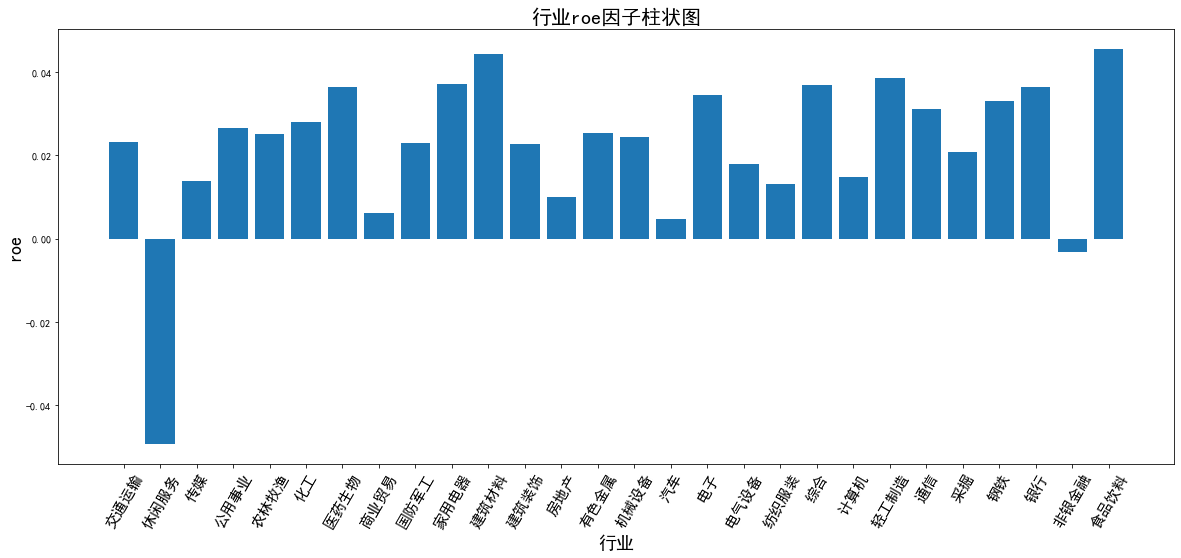

<Figure size 432x288 with 0 Axes>

In [50]:
####行业换手率因子柱状图 (数据采纳2020.12.31各行业均值)

plt.figure(figsize=(20,8))
x=industry_factor_2['industry_name']
y=industry_factor_2['ROE']
plt.bar(x,y)
plt.title('行业roe因子柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(0,6,1)
plt.xlabel('行业',fontsize=18)
plt.ylabel('roe',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('行业roe因子柱状图.png')

In [102]:
# 行业因子排名表格，数据：2015-2020年最后一个交易日数据行业均值

industry_rank=industry_factor[(industry_factor['trade_date']=='2020-12-31')|(industry_factor['trade_date']=='2019-12-31')|(industry_factor['trade_date']=='2018-12-28')|(industry_factor['trade_date']=='2017-12-29')|(industry_factor['trade_date']=='2016-12-30')|(industry_factor['trade_date']=='2015-12-31')]
industry_rank_1=industry_rank.groupby(['trade_date','industry_name'])['ROE'].mean()
industry_rank_2=pd.DataFrame(industry_rank_1).reset_index()
industry_rank_2['年份']=industry_rank_2['trade_date'].dt.year
industry_rank_2=industry_rank_2.rename(columns={'industry_name':'行业'})
industry_rank_2['rank']=industry_rank_2.groupby(['年份'])['ROE'].rank(ascending=False)
industry_rank_3=industry_rank_2.set_index(['行业','年份'])['rank'].unstack()
file='行业ROE因子排名.xlsx'
industry_rank_3.to_excel(file)

In [103]:
industry_rank_3

年份    2015  2016  2017  2018  2019  2020
行业                                      
交通运输  15.0  10.0  11.0  11.0  18.0  16.0
休闲服务   8.0  24.0   3.0  25.0  26.0  28.0
传媒     1.0   5.0  15.0  19.0  27.0  22.0
公用事业   6.0  13.0  23.0  18.0  19.0  12.0
农林牧渔  14.0  11.0  25.0  14.0  14.0  14.0
化工     3.0  27.0   5.0  17.0   9.0  11.0
医药生物   7.0   4.0   6.0   5.0  11.0   6.0
商业贸易  25.0   8.0  27.0  28.0   2.0  25.0
国防军工  23.0  22.0  24.0  26.0  25.0  17.0
家用电器  11.0   7.0  12.0   9.0  17.0   4.0
建筑材料  28.0  25.0  28.0   4.0   7.0   2.0
建筑装饰   9.0  12.0   9.0  13.0  28.0  18.0
房地产   17.0  21.0  21.0  24.0  13.0  24.0
有色金属  20.0  16.0   8.0  23.0  22.0  13.0
机械设备  19.0  23.0  20.0  15.0  12.0  15.0
汽车    26.0   9.0  13.0  10.0  20.0  26.0
电子    16.0  18.0   7.0   7.0   4.0   8.0
电气设备  12.0  19.0  18.0  21.0  21.0  20.0
纺织服装  22.0  20.0  26.0  20.0  24.0  23.0
综合    21.0  26.0  16.0  16.0   1.0   5.0
计算机   18.0  15.0  19.0   8.0  16.0  21.0
轻工制造  13.0  17.0  10.0   6.0  10.0   3.0
通信    10.0  14.0  22.0  27.0  15.0  10.0
采掘    24.0  28.0  14.0  12.0   6.0  19.0
钢铁    27.0   3.0   1.0   1.0   3.0   9.0
银行     2.0   2.0   4.0   2.0   5.0   7.0
非银金融   4.0   6.0  17.0  22.0  23.0  27.0
食品饮料   5.0   1.0   2.0   3.0   8.0   1.0

In [56]:
industry_factor

ts_code trade_date  close  total_share industry_id industry_name  \
0        000001.SZ 2007-08-16  36.25  208675.8345      005013          金融服务   
1        000001.SZ 2007-08-17  34.88  208675.8345      005013          金融服务   
2        000001.SZ 2007-08-20  37.90  208675.8345      005013          金融服务   
3        000001.SZ 2007-08-21  38.56  208675.8345      005013          金融服务   
4        000001.SZ 2007-08-22  38.59  208675.8345      005013          金融服务   
...            ...        ...    ...          ...         ...           ...   
8785480  689009.SH 2022-03-22  46.30   70788.7210      011024          机械设备   
8785481  689009.SH 2022-03-23  46.21   70788.7210      011024          机械设备   
8785482  689009.SH 2022-03-25  45.23   70788.7210      011024          机械设备   
8785483  689009.SH 2022-03-28  45.00   70788.7210      011024          机械设备   
8785484  689009.SH 2022-03-29  45.11   70788.7210      011024          机械设备   

              ROE     firm_size  
0        0.157025  7.564499e+06  
1        0.157025  7.278613e+06  
2        0.157025  7.908814e+06  
3        0.157025  8.046540e+06  
4        0.157025  8.052800e+06  
...           ...           ...  
8785480  0.098573  3.277518e+06  
8785481  0.098573  3.271147e+06  
8785482  0.098573  3.201774e+06  
8785483  0.098573  3.185492e+06  
8785484  0.098573  3.193279e+06  

[8785485 rows x 8 columns]

In [54]:
# 因子按市值分层：1-5递增  数据为2015-2020年最后一个交易日数据

industry_factor['firm_size']=industry_factor['total_share']*industry_factor['close']
firm_size_group=industry_factor[(industry_factor['trade_date']=='2020-12-31')|(industry_factor['trade_date']=='2019-12-31')|(industry_factor['trade_date']=='2018-12-28')|(industry_factor['trade_date']=='2017-12-29')|(industry_factor['trade_date']=='2016-12-30')|(industry_factor['trade_date']=='2015-12-31')]
firm_size_group['Group_ID']=firm_size_group.groupby(['trade_date'])['firm_size'].transform(lambda x:pd.qcut(x,[0,0.2,0.4,0.6,0.8,1],labels=['1','2','3','4','5']))
firm_size_group_1=pd.DataFrame(firm_size_group.groupby(['trade_date','Group_ID'])['ROE'].mean()).reset_index()
firm_size_group_1['year']=firm_size_group_1['trade_date'].dt.year

<ipython-input-54-ca7f313a1895>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firm_size_group['Group_ID']=firm_size_group.groupby(['trade_date'])['firm_size'].transform(lambda x:pd.qcut(x,[0,0.2,0.4,0.6,0.8,1],labels=['1','2','3','4','5']))


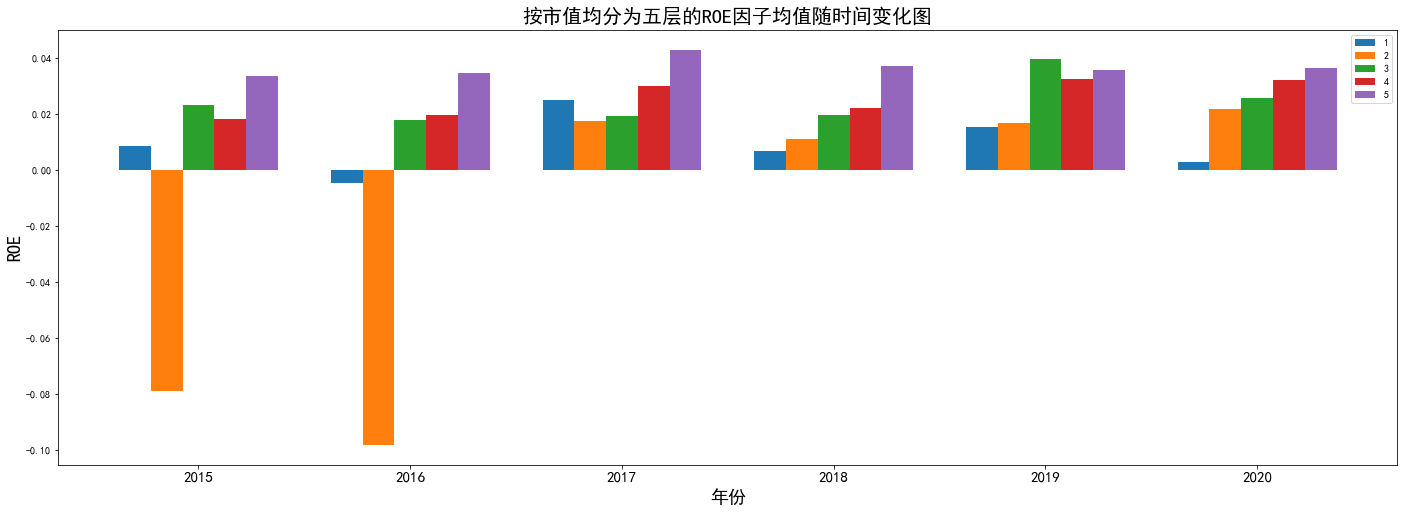

<Figure size 432x288 with 0 Axes>

In [55]:
# 按市值均分为五层的因子均值随时间变化图 数据为2015-2020年最后一个交易日数据

x=pd.Series(np.unique(firm_size_group_1['year']))
labels=['2015','2016','2017','2018','2019','2020']


y1=firm_size_group_1[firm_size_group_1['Group_ID']=='1'].ROE
y2=firm_size_group_1[firm_size_group_1['Group_ID']=='2'].ROE
y3=firm_size_group_1[firm_size_group_1['Group_ID']=='3'].ROE
y4=firm_size_group_1[firm_size_group_1['Group_ID']=='4'].ROE
y5=firm_size_group_1[firm_size_group_1['Group_ID']=='5'].ROE

width=0.15
pos=np.arange(len(x))

plt.figure(figsize=(24,8))
plt.bar(pos-2*width,y1,width,label='1')
plt.bar(pos-1*width,y2,width,label='2')
plt.bar(pos,y3,width,label='3')
plt.bar(pos+1*width,y4,width,label='4')
plt.bar(pos+2*width,y5,width,label='5')
# plt.grid()
plt.legend() # 图例
plt.title('按市值均分为五层的ROE因子均值随时间变化图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
plt.xticks(pos,labels=labels,fontsize=15)
# plt.yticks(y,fontsize=15)
# # plt.ylim(0,6,1)
plt.xlabel('年份',fontsize=18)
plt.ylabel('ROE',fontsize=18)

plt.show()
plt.savefig('按市值均分为五层的ROE因子均值随时间变化图.png')

In [57]:
# 因子与市值的相关系数变化:不分股票，一年所有数据进行corr计算 2015-2020

industry_factor['year']=industry_factor['trade_date'].dt.year
corr=industry_factor[(industry_factor['trade_date']>'2014-12-31')&(industry_factor['trade_date']<'2021-01-01')]
corr_1=pd.DataFrame(corr.groupby(['year'])['ROE'].corr(corr['firm_size'])).reset_index()
corr_1=corr_1.rename(columns={'ROE':'corr'})

# 因子与市值的相关系数变化:不分股票，一个交易日所有数据进行corr计算
corr_2=pd.DataFrame(corr.groupby(['trade_date'])['ROE'].corr(corr['firm_size'])).reset_index()
corr_2=corr_2.rename(columns={'ROE':'corr'})

In [58]:
corr_1

year      corr
0  2015  0.009484
1  2016  0.009592
2  2017  0.004847
3  2018  0.004639
4  2019 -0.000356
5  2020  0.027539

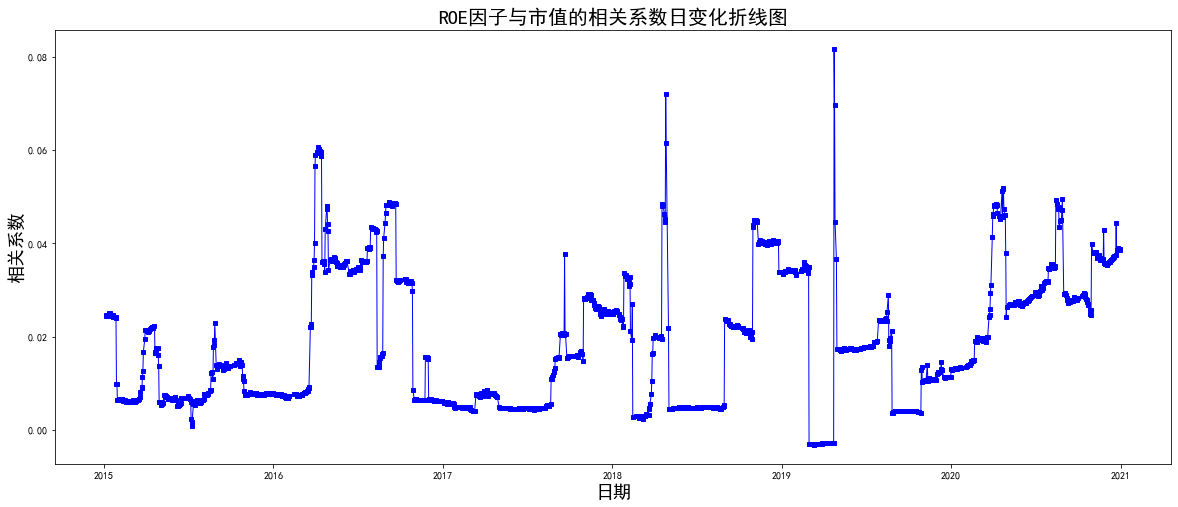

<Figure size 432x288 with 0 Axes>

In [59]:
####因子与市值的相关系数日变化折线图  2015-2020

plt.figure(figsize=(20,8))
x=corr_2['trade_date']
y=corr_2['corr']
plt.plot(x,y,lw=1,c='blue',marker='s',ms=4,label='ROE因子与市值的日相关系数')
plt.title('ROE因子与市值的相关系数日变化折线图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.15,0.05,0.05)
plt.xlabel('日期',fontsize=18)
plt.ylabel('相关系数',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('ROE因子与市值的相关系数日变化折线图.png')

In [60]:
industry_factor

ts_code trade_date  close  total_share industry_id industry_name  \
0        000001.SZ 2007-08-16  36.25  208675.8345      005013          金融服务   
1        000001.SZ 2007-08-17  34.88  208675.8345      005013          金融服务   
2        000001.SZ 2007-08-20  37.90  208675.8345      005013          金融服务   
3        000001.SZ 2007-08-21  38.56  208675.8345      005013          金融服务   
4        000001.SZ 2007-08-22  38.59  208675.8345      005013          金融服务   
...            ...        ...    ...          ...         ...           ...   
8785480  689009.SH 2022-03-22  46.30   70788.7210      011024          机械设备   
8785481  689009.SH 2022-03-23  46.21   70788.7210      011024          机械设备   
8785482  689009.SH 2022-03-25  45.23   70788.7210      011024          机械设备   
8785483  689009.SH 2022-03-28  45.00   70788.7210      011024          机械设备   
8785484  689009.SH 2022-03-29  45.11   70788.7210      011024          机械设备   

              ROE     firm_size  year  
0        0.157025  7.564499e+06  2007  
1        0.157025  7.278613e+06  2007  
2        0.157025  7.908814e+06  2007  
3        0.157025  8.046540e+06  2007  
4        0.157025  8.052800e+06  2007  
...           ...           ...   ...  
8785480  0.098573  3.277518e+06  2022  
8785481  0.098573  3.271147e+06  2022  
8785482  0.098573  3.201774e+06  2022  
8785483  0.098573  3.185492e+06  2022  
8785484  0.098573  3.193279e+06  2022  

[8785485 rows x 9 columns]

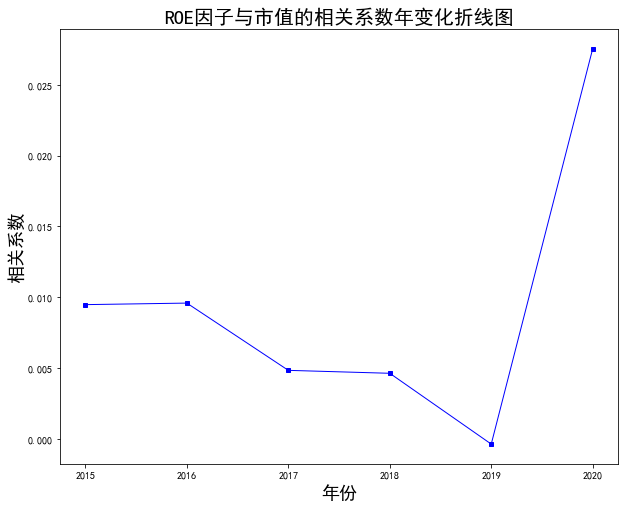

<Figure size 432x288 with 0 Axes>

In [62]:
####因子与市值的相关系数年变化折线图  2015-2020

plt.figure(figsize=(10,8))
x=corr_1['year']
y=corr_1['corr']
plt.plot(x,y,lw=1,c='blue',marker='s',ms=4,label='ROE因子与市值的年相关系数')
plt.title('ROE因子与市值的相关系数年变化折线图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('年份',fontsize=18)
plt.ylabel('相关系数',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('ROE因子与市值的相关系数年变化折线图.png')

In [63]:
# 因子处理：去极值处理(winsorize, 0.03)以及中性化处理:先进行行业中性化(减行业均值)后在进行市值中性化（回归取残差），最后做标准化()

industry_factor=industry_factor[(industry_factor['trade_date']>'2014-12-31')&(industry_factor['trade_date']<'2021-01-01')]
industry_factor['win_ROE']=winsorize(industry_factor.ROE,limits=[0.03,0.03]) # 去极值处理(winsorize,0.03)

<ipython-input-63-daf746ffa595>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry_factor['win_ROE']=winsorize(industry_factor.ROE,limits=[0.03,0.03]) # 去极值处理(winsorize,0.03)


In [66]:
industry_factor

ts_code trade_date  close   total_share industry_id industry_name  \
1709     000001.SZ 2015-01-05  16.02  1.142489e+06      011018            银行   
1710     000001.SZ 2015-01-06  15.78  1.142489e+06      011018            银行   
1711     000001.SZ 2015-01-07  15.48  1.142489e+06      011018            银行   
1712     000001.SZ 2015-01-08  14.96  1.142489e+06      011018            银行   
1713     000001.SZ 2015-01-09  15.08  1.142489e+06      011018            银行   
...            ...        ...    ...           ...         ...           ...   
8785280  689009.SH 2020-12-24  73.10  7.040917e+03      011024          机械设备   
8785281  689009.SH 2020-12-25  75.10  7.040917e+03      011024          机械设备   
8785282  689009.SH 2020-12-28  80.10  7.040917e+03      011024          机械设备   
8785283  689009.SH 2020-12-30  80.91  7.040917e+03      011024          机械设备   
8785284  689009.SH 2020-12-31  85.82  7.040917e+03      011024          机械设备   

              ROE     firm_size  year   win_ROE  
1709     0.046535  1.830268e+07  2015  0.046535  
1710     0.046535  1.802848e+07  2015  0.046535  
1711     0.046535  1.768574e+07  2015  0.046535  
1712     0.046535  1.709164e+07  2015  0.046535  
1713     0.046535  1.722874e+07  2015  0.046535  
...           ...           ...   ...       ...  
8785280  0.036202  5.146910e+05  2020  0.036202  
8785281  0.036202  5.287728e+05  2020  0.036202  
8785282  0.036202  5.639774e+05  2020  0.036202  
8785283  0.036202  5.696806e+05  2020  0.036202  
8785284  0.036202  6.042515e+05  2020  0.036202  

[4533767 rows x 10 columns]

In [67]:
# 行业中性化（减行业均值）

neu_ind_1=pd.DataFrame(industry_factor.groupby(['trade_date','industry_name'])['win_ROE'].mean())
neu_ind_1=neu_ind_1.rename(columns={'win_ROE':'ind_mean'}).reset_index()
neu_ind_2=pd.merge(neu_ind_1,industry_factor,on=['trade_date','industry_name'],how='right')
neu_ind_2['ind_neu_ROE']=neu_ind_2['win_ROE']-neu_ind_2['ind_mean']

In [68]:
# 市值中性化（回归取残差）
# position=neu_ind_2.isnull().stack().index.tolist()

def lr_resid(sdf):
    lr=LinearRegression().fit(sdf[['firm_size']],sdf['ind_neu_ROE'])
    return sdf['ind_neu_ROE']-lr.predict(sdf[['firm_size']])

# %%time
neu_ind_2=neu_ind_2.dropna(subset=['ind_neu_ROE','firm_size'])
neu_ind_2['fz_ind_neu_ROE']=neu_ind_2.groupby("trade_date").apply(lr_resid).rename("fz_ind_neu_ROE").reset_index(level=0)['fz_ind_neu_ROE']


In [69]:
# 标准化：Z-score标准化，z=（个体观察值-当天总体数均值）/当天总体数据标准差

std_1=pd.DataFrame(neu_ind_2.groupby(['trade_date'])['fz_ind_neu_ROE'].mean()).reset_index().rename(columns={'fz_ind_neu_ROE':'date_mean'})
std_2=pd.DataFrame(neu_ind_2.groupby(['trade_date'])['fz_ind_neu_ROE'].std()).reset_index().rename(columns={'fz_ind_neu_ROE':'date_std'})
std_3=pd.merge(std_1,std_2,on=['trade_date'])
std_4=pd.merge(neu_ind_2,std_3,on=['trade_date'],how='left').sort_values(by=['trade_date','ts_code'])
std_4['std_neu_ROE']=(std_4['fz_ind_neu_ROE']-std_4['date_mean'])/std_4['date_std']

In [70]:
# 整体结果做OLS回归，即因子值对下一个日期回报的进行回归

# 计算回报
ret_1=std_4.sort_values(by=['ts_code','trade_date']).drop_duplicates(subset=['ts_code','trade_date']).set_index(['trade_date','ts_code'])
ret_2=ret_1['close'].unstack()
ret_3=(ret_2.shift(-1)-ret_2)/ret_2
ret_4=ret_3.stack().reset_index().rename(columns={0:'ret_t1'})
ret_5=pd.merge(ret_4,std_4,on=['trade_date','ts_code'],how='right')
# ret = ret_5.pivot(index = 'trade_date',columns = 'ts_code',values = 'close').pct_change(1).shift(-1).fillna(0)

In [ ]:
ret_5

In [71]:
# 做回归

OLS=sm.ols(formula="ret_t1~std_neu_ROE",data=ret_5).fit()
OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ret_t1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     142.4
Date:                Sun, 10 Apr 2022   Prob (F-statistic):           7.96e-33
Time:                        11:48:12   Log-Likelihood:             8.9779e+06
No. Observations:             4520139   AIC:                        -1.796e+07
Df Residuals:                 4520137   BIC:                        -1.796e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0002   1.56e-05     10.656      0.000       0.000       0.000
std_neu_ROE     0.0002   1.56e-05     11.933      0.000       0.000       0.000
==============================================================================
Omnibus:                  2001351.035   Durbin-Watson:                   1.269
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        115179400.420
Skew:                          -1.342   Prob(JB):                         0.00
Kurtosis:                      27.583   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
# IC计算

# Normal IC
IC_1=pd.DataFrame(ret_5.groupby(['trade_date'])['std_neu_ROE'].corr(ret_5['ret_t1'])).reset_index()
IC_1=IC_1.rename(columns={'std_neu_ROE':'Normal_IC'})



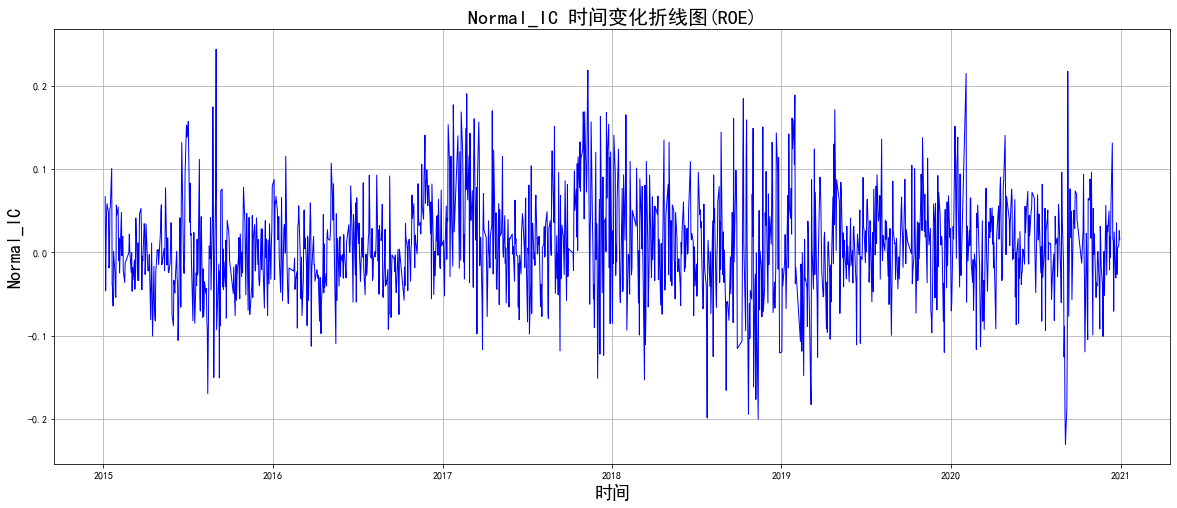

<Figure size 432x288 with 0 Axes>

In [74]:
# Normal IC 时间变化折线图

plt.figure(figsize=(20,8))
x=IC_1['trade_date']
y=IC_1['Normal_IC']
plt.plot(x,y,lw=1,c='blue',ms=4,label='Normal_IC 时间变化折线图')
plt.title('Normal_IC 时间变化折线图(ROE)',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('时间',fontsize=18)
plt.ylabel('Normal_IC',fontsize=18)
plt.grid()
plt.show()
plt.savefig('Normal_IC 时间变化折线图(ROE).png')



In [75]:
# rank IC 排序升序
IC_2=ret_5
IC_2['fac_rank']=IC_2.groupby(['trade_date'])['std_neu_ROE'].rank()
IC_3=pd.DataFrame(IC_2.groupby(['trade_date'])['fac_rank'].corr(IC_2['ret_t1'])).reset_index()
IC_3=IC_3.rename(columns={'fac_rank':'rank_IC'})


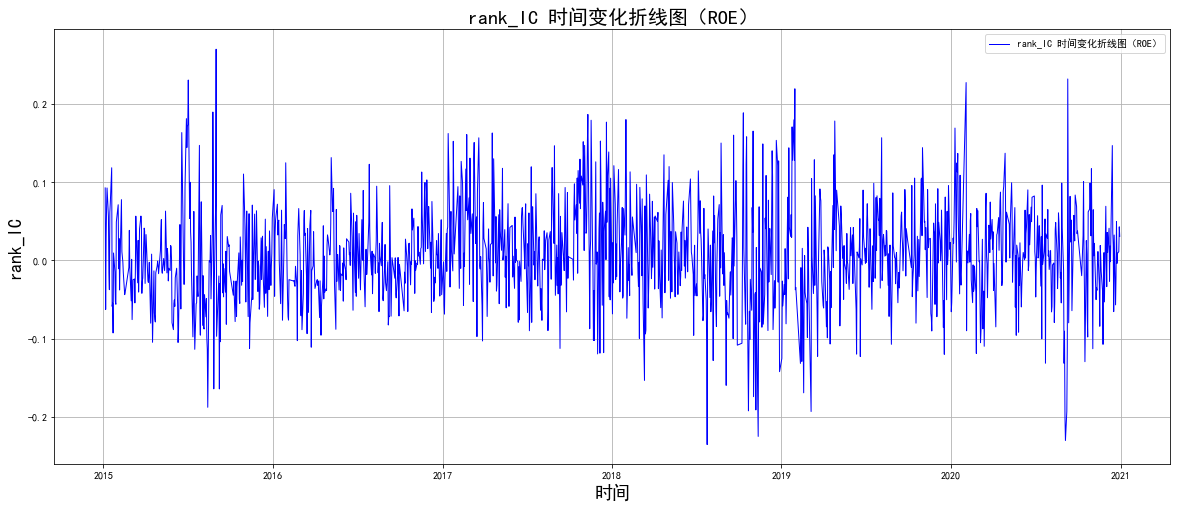

<Figure size 432x288 with 0 Axes>

In [76]:
# rank IC 时间变化折线图

plt.figure(figsize=(20,8))
x=IC_3['trade_date']
y=IC_3['rank_IC']
plt.plot(x,y,lw=1,c='blue',ms=4,label='rank_IC 时间变化折线图（ROE）')
plt.title('rank_IC 时间变化折线图（ROE）',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('时间',fontsize=18)
plt.ylabel('rank_IC',fontsize=18)
plt.legend()
plt.grid()
plt.show()
plt.savefig('rank_IC 时间变化折线图（ROE）.png')



In [77]:
IC_4=pd.DataFrame()
Normal_IC=pd.Series({"mean":IC_1['Normal_IC'].mean(),"std":IC_1['Normal_IC'].std(),"IRIC":IC_1['Normal_IC'].mean()/IC_1['Normal_IC'].std(),"skew":IC_1['Normal_IC'].skew()},name="Normal_IC")
rank_IC=pd.Series({"mean":IC_3['rank_IC'].mean(),"std":IC_3['rank_IC'].std(),"IRIC":IC_3['rank_IC'].mean()/IC_3['rank_IC'].std(),"skew":IC_3['rank_IC'].skew()},name="rank_IC")
IC_4=IC_4.append(Normal_IC)
IC_4=IC_4.append(rank_IC)


In [78]:
IC_4

IRIC      mean      skew       std
Normal_IC  0.129567  0.007958  0.156947  0.061418
rank_IC    0.102049  0.006517  0.142022  0.063857

In [79]:
# 分层测试
Group_test=ret_5.copy()
Group_test['Group_ID']=Group_test.groupby(['trade_date'])['std_neu_ROE'].transform(lambda x:pd.qcut(x,[0,0.2,0.4,0.6,0.8,1],labels=['1','2','3','4','5']))
Group_test_1=pd.DataFrame(Group_test.groupby(['trade_date','Group_ID'])['ret_t1'].mean()).reset_index().rename(columns={'ret_t1':'Group_ret_mean'})


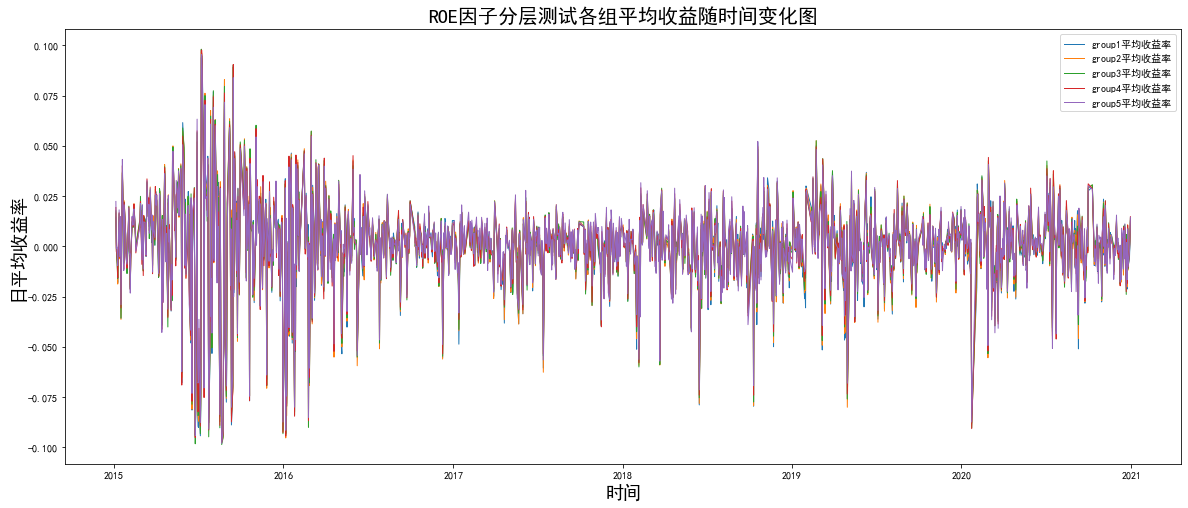

<Figure size 432x288 with 0 Axes>

In [80]:
# 因子分层测试各组日平均收益随时间变化图

x=pd.Series(np.unique(Group_test_1['trade_date']))
y1=Group_test_1[Group_test_1['Group_ID']=='1']['Group_ret_mean']
y2=Group_test_1[Group_test_1['Group_ID']=='2']['Group_ret_mean']
y3=Group_test_1[Group_test_1['Group_ID']=='3']['Group_ret_mean']
y4=Group_test_1[Group_test_1['Group_ID']=='4']['Group_ret_mean']
y5=Group_test_1[Group_test_1['Group_ID']=='5']['Group_ret_mean']

plt.figure(figsize=(20,8))
plt.plot(x,y1,lw=1,ms=4,label='group1平均收益率')
plt.plot(x,y2,lw=1,ms=4,label='group2平均收益率')
plt.plot(x,y3,lw=1,ms=4,label='group3平均收益率')
plt.plot(x,y4,lw=1,ms=4,label='group4平均收益率')
plt.plot(x,y5,lw=1,ms=4,label='group5平均收益率')
plt.title('ROE因子分层测试各组平均收益随时间变化图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('时间',fontsize=18)
plt.ylabel('日平均收益率',fontsize=18)
plt.legend()
# plt.grid()
plt.show()
plt.savefig('ROE因子分层测试各组平均收益随时间变化图.png')

In [81]:
# 计算各组累计收益率

Group_test_1['cum_rev'] =Group_test_1.sort_values(by=['Group_ID','trade_date']).groupby(['Group_ID'])['Group_ret_mean'].apply(lambda x:(1 + x).cumprod())

In [82]:
Group_test_1.sort_values(by=['Group_ID','trade_date'])

trade_date Group_ID  Group_ret_mean   cum_rev
0    2015-01-05        1        0.014509  1.014509
5    2015-01-06        1        0.002129  1.016669
10   2015-01-07        1       -0.002615  1.014010
15   2015-01-08        1       -0.008695  1.005194
20   2015-01-09        1       -0.018041  0.987059
...         ...      ...             ...       ...
7289 2020-12-25        5       -0.010217  1.762638
7294 2020-12-28        5       -0.002498  1.758236
7299 2020-12-29        5        0.005932  1.768665
7304 2020-12-30        5        0.014429  1.794184
7309 2020-12-31        5             NaN       NaN

[7310 rows x 4 columns]

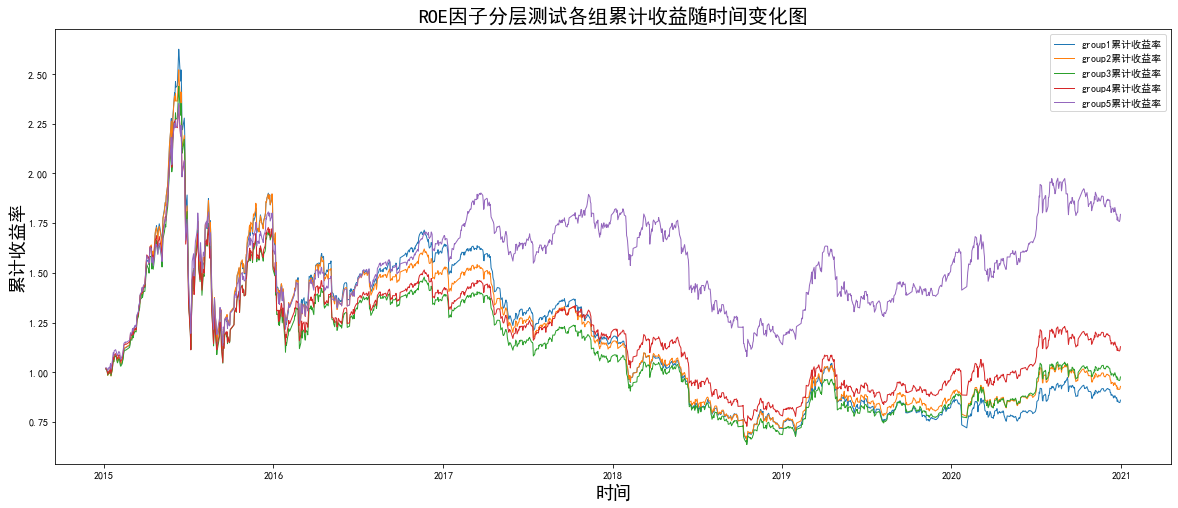

<Figure size 432x288 with 0 Axes>

In [83]:
# 因子分层测试各组累计收益随时间变化图

x=pd.Series(np.unique(Group_test_1['trade_date']))
y1=Group_test_1[Group_test_1['Group_ID']=='1']['cum_rev']
y2=Group_test_1[Group_test_1['Group_ID']=='2']['cum_rev']
y3=Group_test_1[Group_test_1['Group_ID']=='3']['cum_rev']
y4=Group_test_1[Group_test_1['Group_ID']=='4']['cum_rev']
y5=Group_test_1[Group_test_1['Group_ID']=='5']['cum_rev']

plt.figure(figsize=(20,8))
plt.plot(x,y1,lw=1,ms=4,label='group1累计收益率')
plt.plot(x,y2,lw=1,ms=4,label='group2累计收益率')
plt.plot(x,y3,lw=1,ms=4,label='group3累计收益率')
plt.plot(x,y4,lw=1,ms=4,label='group4累计收益率')
plt.plot(x,y5,lw=1,ms=4,label='group5累计收益率')
plt.title('ROE因子分层测试各组累计收益随时间变化图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('时间',fontsize=18)
plt.ylabel('累计收益率',fontsize=18)
plt.legend()
# plt.grid()
plt.show()
plt.savefig('ROE因子分层测试各组累计收益随时间变化图.png')

In [84]:
# 计算各组年化收益率&年化波动率&夏普比率&最大回撤


Annual_1=pd.DataFrame(Group_test_1.groupby(['Group_ID'])['Group_ret_mean'].mean()).reset_index().rename(columns={'Group_ret_mean':'aver_ret'})
Annual_2=pd.DataFrame(Group_test_1.groupby(['Group_ID'])['Group_ret_mean'].var()).reset_index().rename(columns={'Group_ret_mean':'volatility'})
Annual_3=pd.merge(Annual_1,Annual_2,on=['Group_ID'])
Annual_3['Annual_aver_ret']=(1+Annual_3['aver_ret'])**252-1
Annual_3['Annual_vol']=((Annual_3['volatility'])*252)**0.5
Annual_3['Annual_Sharpe']=252*Annual_3['aver_ret']/Annual_3['Annual_vol']

arr_1=Group_test_1[Group_test_1['Group_ID']=='1']['cum_rev']
j_1 = np.argmax((np.maximum.accumulate(arr_1) - arr_1)/np.maximum.accumulate(arr_1)) # end of the period
i_1 = np.argmax(arr_1[:j_1]) # start of period
MaxDrawdown_1=(1-arr_1.iloc[j_1]/arr_1.iloc[i_1])

arr_2=Group_test_1[Group_test_1['Group_ID']=='2']['cum_rev']
j_2 = np.argmax((np.maximum.accumulate(arr_2) - arr_2)/np.maximum.accumulate(arr_2)) # end of the period
i_2 = np.argmax(arr_2[:j_2]) # start of period
MaxDrawdown_2=(1-arr_2.iloc[j_2]/arr_2.iloc[i_2])


arr_3=Group_test_1[Group_test_1['Group_ID']=='3']['cum_rev']
j_3 = np.argmax((np.maximum.accumulate(arr_3) - arr_3)/np.maximum.accumulate(arr_3)) # end of the period
i_3 = np.argmax(arr_3[:j_3]) # start of period
MaxDrawdown_3=(1-arr_3.iloc[j_3]/arr_3.iloc[i_3])


arr_4=Group_test_1[Group_test_1['Group_ID']=='4']['cum_rev']
j_4 = np.argmax((np.maximum.accumulate(arr_4) - arr_4)/np.maximum.accumulate(arr_4)) # end of the period
i_4 = np.argmax(arr_4[:j_4]) # start of period
MaxDrawdown_4=(1-arr_4.iloc[j_4]/arr_4.iloc[i_4])


arr_5=Group_test_1[Group_test_1['Group_ID']=='5']['cum_rev']
j_5 = np.argmax((np.maximum.accumulate(arr_5) - arr_5)/np.maximum.accumulate(arr_5)) # end of the period
i_5 = np.argmax(arr_5[:j_5]) # start of period
MaxDrawdown_5=(1-arr_5.iloc[j_5]/arr_5.iloc[i_5])




Annual_4=pd.DataFrame()
Annual_aver_ret=pd.Series({"Group1":float(Annual_3[Annual_3['Group_ID']=='1']['Annual_aver_ret']),"Group2":float(Annual_3[Annual_3['Group_ID']=='2']['Annual_aver_ret']),"Group3":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_aver_ret']),"Group4":float(Annual_3[Annual_3['Group_ID']=='4']['Annual_aver_ret']),"Group5":float(Annual_3[Annual_3['Group_ID']=='5']['Annual_aver_ret'])},name="Annual_average_return")
Annual_vol=pd.Series({"Group1":float(Annual_3[Annual_3['Group_ID']=='1']['Annual_vol']),"Group2":float(Annual_3[Annual_3['Group_ID']=='2']['Annual_vol']),"Group3":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_vol']),"Group4":float(Annual_3[Annual_3['Group_ID']=='4']['Annual_vol']),"Group5":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_vol'])},name="Annual_volatility")
Annual_sharpe=pd.Series({"Group1":float(Annual_3[Annual_3['Group_ID']=='1']['Annual_Sharpe']),"Group2":float(Annual_3[Annual_3['Group_ID']=='2']['Annual_Sharpe']),"Group3":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_Sharpe']),"Group4":float(Annual_3[Annual_3['Group_ID']=='4']['Annual_Sharpe']),"Group5":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_Sharpe'])},name="Annual_Sharpe_Ratio")
Annual_MaxDrawdown=pd.Series({"Group1":MaxDrawdown_1,"Group2":MaxDrawdown_2,"Group3":MaxDrawdown_3,"Group4":MaxDrawdown_4,"Group5":MaxDrawdown_5},name="Annual_MaxDrawdown")


Annual_4=Annual_4.append(Annual_aver_ret)
Annual_4=Annual_4.append(Annual_vol)
Annual_4=Annual_4.append(Annual_sharpe)
Annual_4=Annual_4.append(Annual_MaxDrawdown)

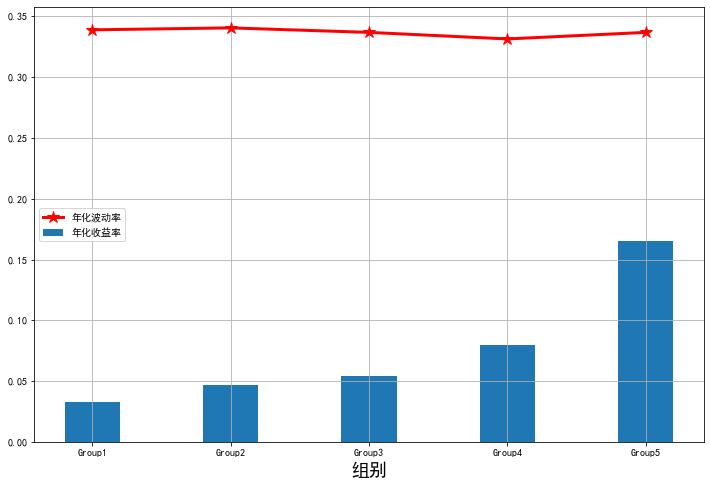

<Figure size 432x288 with 0 Axes>

In [85]:
# 年化数据组合图：年化收益&年化波动率
Annual_5=Annual_4.T.reset_index()
x=Annual_5['index']
y1=Annual_5['Annual_average_return']
y2=Annual_5['Annual_volatility']
# y3=Annual_5['Annual_Sharpe_Ratio']
# y4=Annual_5['Annual_MaxDrawdown']


plt.figure(figsize=(12,8))
plt.bar(x,y1,width=0.4,label='年化收益率')
plt.plot(x,y2,lw=3,ms=13,color='red',marker='*',label='年化波动率')
# plt.plot(x,y3,lw=3,ms=13,marker='^',label='年化夏普比')
# plt.plot(x,y4,lw=3,ms=13,marker='x',label='最大回撤率')

# for a,b in zip(x,y2):
#     plt.text(a,b,b,ha='center',va='bottom',fontsize=20)
# plt.title('年化数据组合图：年化收益&年化波动率',fontsize=20,fontweight='heavy',verticalalignment='baseline')

# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('组别',fontsize=18)
# plt.ylabel('累计收益率',fontsize=18)
plt.legend()
plt.grid()
plt.show()
plt.savefig('ROE年化数据组合图：年化收益&年化波动率.png')

In [104]:
Annual_5

index  Annual_average_return  Annual_volatility  Annual_Sharpe_Ratio  \
0  Group1               0.032541           0.338814             0.094519   
1  Group2               0.046947           0.340419             0.134782   
2  Group3               0.054653           0.336718             0.158048   
3  Group4               0.079367           0.331325             0.230547   
4  Group5               0.165469           0.336718             0.158048   

   Annual_MaxDrawdown  
0            0.753093  
1            0.739743  
2            0.739321  
3            0.689463  
4            0.541330

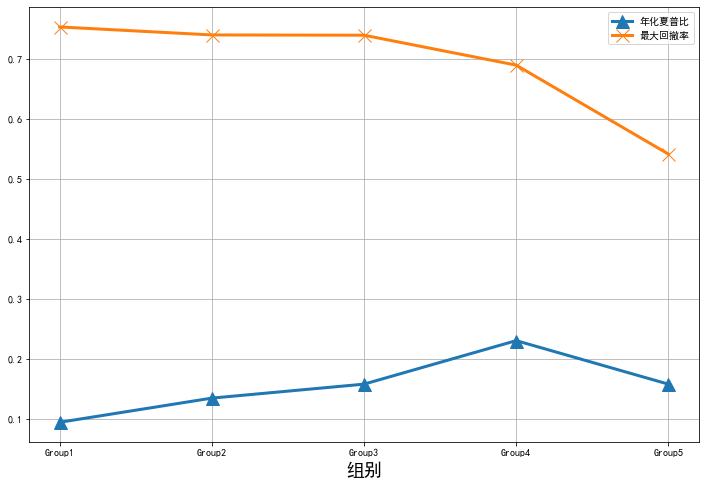

<Figure size 432x288 with 0 Axes>

In [86]:
# 年化数据组合图：最大回撤&年化夏普
Annual_5=Annual_4.T.reset_index()
x=Annual_5['index']
y3=Annual_5['Annual_Sharpe_Ratio']
y4=Annual_5['Annual_MaxDrawdown']


plt.figure(figsize=(12,8))
plt.plot(x,y3,lw=3,ms=13,marker='^',label='年化夏普比')
plt.plot(x,y4,lw=3,ms=13,marker='x',label='最大回撤率')

# for a,b in zip(x,y2):
#     plt.text(a,b,b,ha='center',va='bottom',fontsize=20)
# plt.title('年化数据组合图：年化收益&年化波动率',fontsize=20,fontweight='heavy',verticalalignment='baseline')

# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('组别',fontsize=18)
# plt.ylabel('累计收益率',fontsize=18)
plt.legend()
plt.grid()
plt.show()
plt.savefig('ROE年化数据组合图：最大回撤&年化夏普.png')

In [87]:
#各行业group1的年化收益

Ind_Group_test=Group_test[Group_test['Group_ID']=='1']
Ind_Group_test_1=pd.DataFrame(Ind_Group_test.groupby(['industry_name'])['ret_t1'].mean()).reset_index().rename(columns={'ret_t1':'ind_aver_ret'})
Ind_Group_test_1['Annual_ret']=(1+Ind_Group_test_1['ind_aver_ret'])**252-1

In [88]:
Ind_Group_test_1

industry_name  ind_aver_ret  Annual_ret
0           交通运输 -1.718124e-04   -0.042376
1           休闲服务  4.273830e-04    0.113689
2             传媒 -7.472798e-04   -0.171704
3           公用事业 -6.680289e-04   -0.154984
4           农林牧渔  5.059638e-04    0.135952
5             化工  1.283082e-04    0.032860
6           医药生物  1.199876e-04    0.030697
7           商业贸易  2.969141e-04    0.077681
8           国防军工  2.041772e-04    0.052794
9           家用电器 -1.880364e-04   -0.046284
10          建筑材料  2.023186e-04    0.052301
11          建筑装饰 -3.113680e-04   -0.075477
12           房地产  1.549315e-05    0.003912
13          有色金属 -2.918043e-04   -0.070906
14          机械设备 -1.840514e-05   -0.004627
15            汽车  1.443921e-04    0.037054
16            电子  3.416825e-04    0.089904
17          电气设备  7.458917e-05    0.018974
18          纺织服装  9.375584e-05    0.023907
19            综合  6.094481e-05    0.015476
20           计算机 -1.511844e-04   -0.037385
21          轻工制造 -3.667310e-04   -0.088290
22            通信 -5.788958e-04   -0.135777
23            采掘 -7.557816e-05   -0.018866
24            钢铁 -2.442551e-04   -0.059703
25            银行  2.175098e-04    0.056336
26          非银金融  3.714550e-07    0.000094
27          食品饮料  1.240971e-04    0.031765

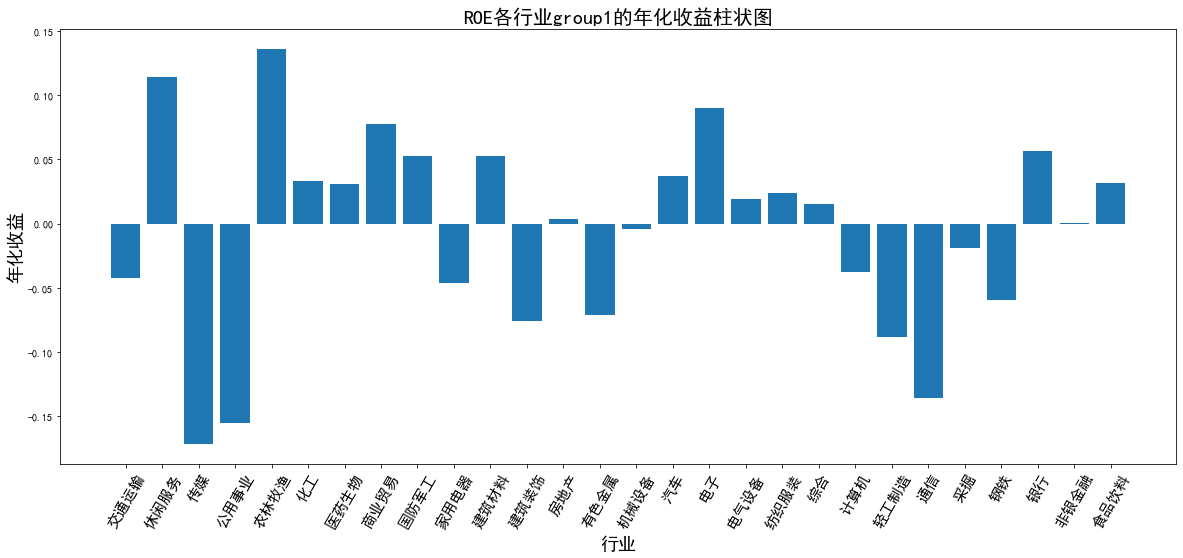

<Figure size 432x288 with 0 Axes>

In [89]:
####各行业group1的年化收益 

plt.figure(figsize=(20,8))
x=Ind_Group_test_1['industry_name']
y=Ind_Group_test_1['Annual_ret']
plt.bar(x,y)
plt.title('ROE各行业group1的年化收益柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(0,6,1)
plt.xlabel('行业',fontsize=18)
plt.ylabel('年化收益',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('ROE各行业group1的年化收益柱状图.png')

In [90]:
# 各个组别的换手率测试

Turnover_test_1=Group_test[Group_test['Group_ID']=='1']
turnover_1 = pd.DataFrame()
turnover_1['trade_date']= Turnover_test_1.trade_date.unique()
turnover_1['turnover'] = 0
    
for i in range(1,turnover_1.shape[0]):
    stock_now = set(Turnover_test_1.loc[Turnover_test_1.trade_date==turnover_1.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_1.loc[Turnover_test_1.trade_date==turnover_1.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_1.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


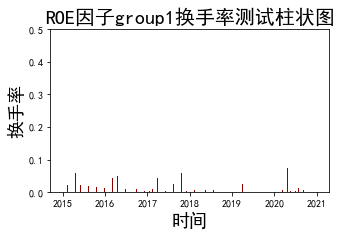

<Figure size 432x288 with 0 Axes>

In [105]:
####group1换手率测试柱状图

plt.figure(figsize=(5,3))
x=turnover_1['trade_date']
y=turnover_1['turnover']
plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('ROE因子group1换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
plt.ylim(0,0.5,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('ROE因子group1换手率测试柱状图.png')

In [92]:
# 各个组别的换手率测试

Turnover_test_2=Group_test[Group_test['Group_ID']=='2']
turnover_2 = pd.DataFrame()
turnover_2['trade_date']= Turnover_test_2.trade_date.unique()
turnover_2['turnover'] = 0
    
for i in range(1,turnover_2.shape[0]):
    stock_now = set(Turnover_test_2.loc[Turnover_test_2.trade_date==turnover_2.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_2.loc[Turnover_test_2.trade_date==turnover_2.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_2.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


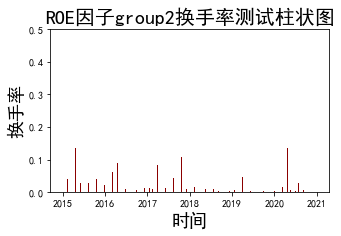

<Figure size 432x288 with 0 Axes>

In [106]:
####group2换手率测试柱状图

plt.figure(figsize=(5,3))
x=turnover_2['trade_date']
y=turnover_2['turnover']
plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('ROE因子group2换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
plt.ylim(0,0.5,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('ROE因子group2换手率测试柱状图.png')

In [94]:
# 各个组别的换手率测试

Turnover_test_3=Group_test[Group_test['Group_ID']=='3']
turnover_3 = pd.DataFrame()
turnover_3['trade_date']= Turnover_test_3.trade_date.unique()
turnover_3['turnover'] = 0
    
for i in range(1,turnover_3.shape[0]):
    stock_now = set(Turnover_test_3.loc[Turnover_test_3.trade_date==turnover_3.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_3.loc[Turnover_test_3.trade_date==turnover_3.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_3.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


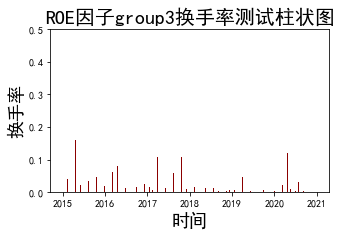

<Figure size 432x288 with 0 Axes>

In [107]:
####group3换手率测试柱状图

plt.figure(figsize=(5,3))
x=turnover_3['trade_date']
y=turnover_3['turnover']
plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('ROE因子group3换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
plt.ylim(0,0.5,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('ROE因子group3换手率测试柱状图.png')

In [96]:
# 各个组别的换手率测试

Turnover_test_4=Group_test[Group_test['Group_ID']=='4']
turnover_4 = pd.DataFrame()
turnover_4['trade_date']= Turnover_test_4.trade_date.unique()
turnover_4['turnover'] = 0
    
for i in range(1,turnover_4.shape[0]):
    stock_now = set(Turnover_test_4.loc[Turnover_test_4.trade_date==turnover_4.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_4.loc[Turnover_test_4.trade_date==turnover_4.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_4.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


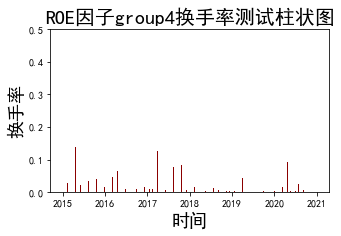

<Figure size 432x288 with 0 Axes>

In [108]:
####group4换手率测试柱状图

plt.figure(figsize=(5,3))
x=turnover_4['trade_date']
y=turnover_4['turnover']
plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('ROE因子group4换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
plt.ylim(0,0.5,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('ROE因子group4换手率测试柱状图.png')

In [99]:
# 各个组别的换手率测试

Turnover_test_5=Group_test[Group_test['Group_ID']=='5']
turnover_5 = pd.DataFrame()
turnover_5['trade_date']= Turnover_test_5.trade_date.unique()
turnover_5['turnover'] = 0
    
for i in range(1,turnover_5.shape[0]):
    stock_now = set(Turnover_test_5.loc[Turnover_test_5.trade_date==turnover_5.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_5.loc[Turnover_test_5.trade_date==turnover_5.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_5.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


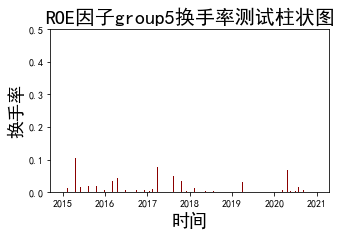

<Figure size 432x288 with 0 Axes>

In [109]:
####group5换手率测试柱状图

plt.figure(figsize=(5,3))
x=turnover_5['trade_date']
y=turnover_5['turnover']
plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('ROE因子group5换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
plt.ylim(0,0.5,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('ROE因子group5换手率测试柱状图.png')

Dropped 1.8% entries from factor data: 1.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 1.8% entries from factor data: 1.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Returns Analysis


1D     5D    10D    20D
Ann. alpha                                     0.069  0.050  0.033  0.006
beta                                          -0.021 -0.048 -0.053 -0.059
Mean Period Wise Return Top Quantile (bps)     3.118  2.189  1.365  0.049
Mean Period Wise Return Bottom Quantile (bps) -1.519 -0.699 -0.288  0.112
Mean Period Wise Spread (bps)                  4.637  2.882  1.645 -0.079

<Figure size 432x288 with 0 Axes>

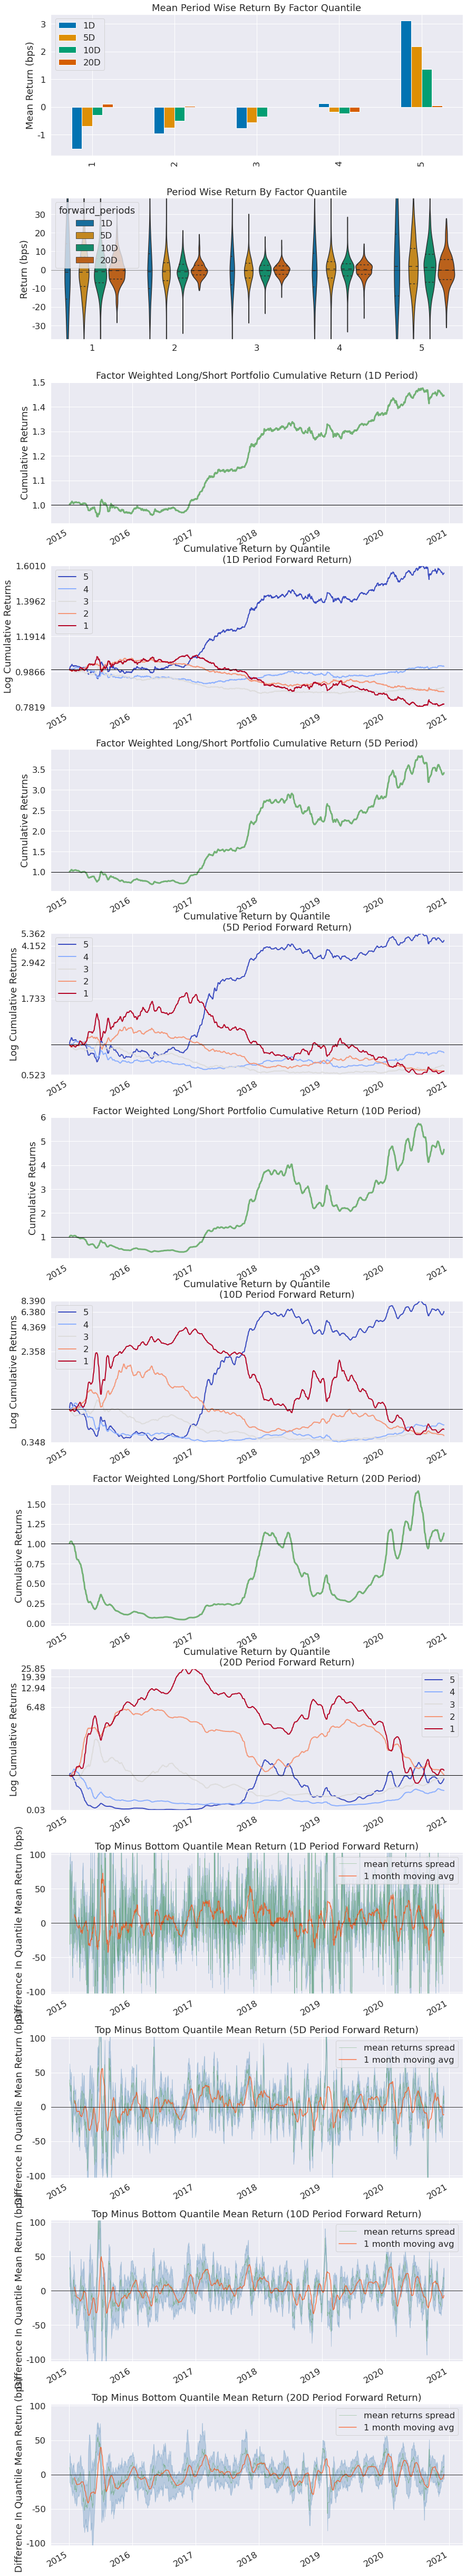

Information Analysis


1D     5D    10D    20D
IC Mean           0.011  0.014  0.014  0.012
IC Std.           0.074  0.089  0.097  0.100
Risk-Adjusted IC  0.145  0.161  0.143  0.118
t-stat(IC)        5.516  6.112  5.445  4.466
p-value(IC)       0.000  0.000  0.000  0.000
IC Skew           0.072 -0.022  0.054  0.111
IC Kurtosis       0.561  0.259 -0.087 -0.293

/usr/lib/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplo

<Figure size 432x288 with 0 Axes>

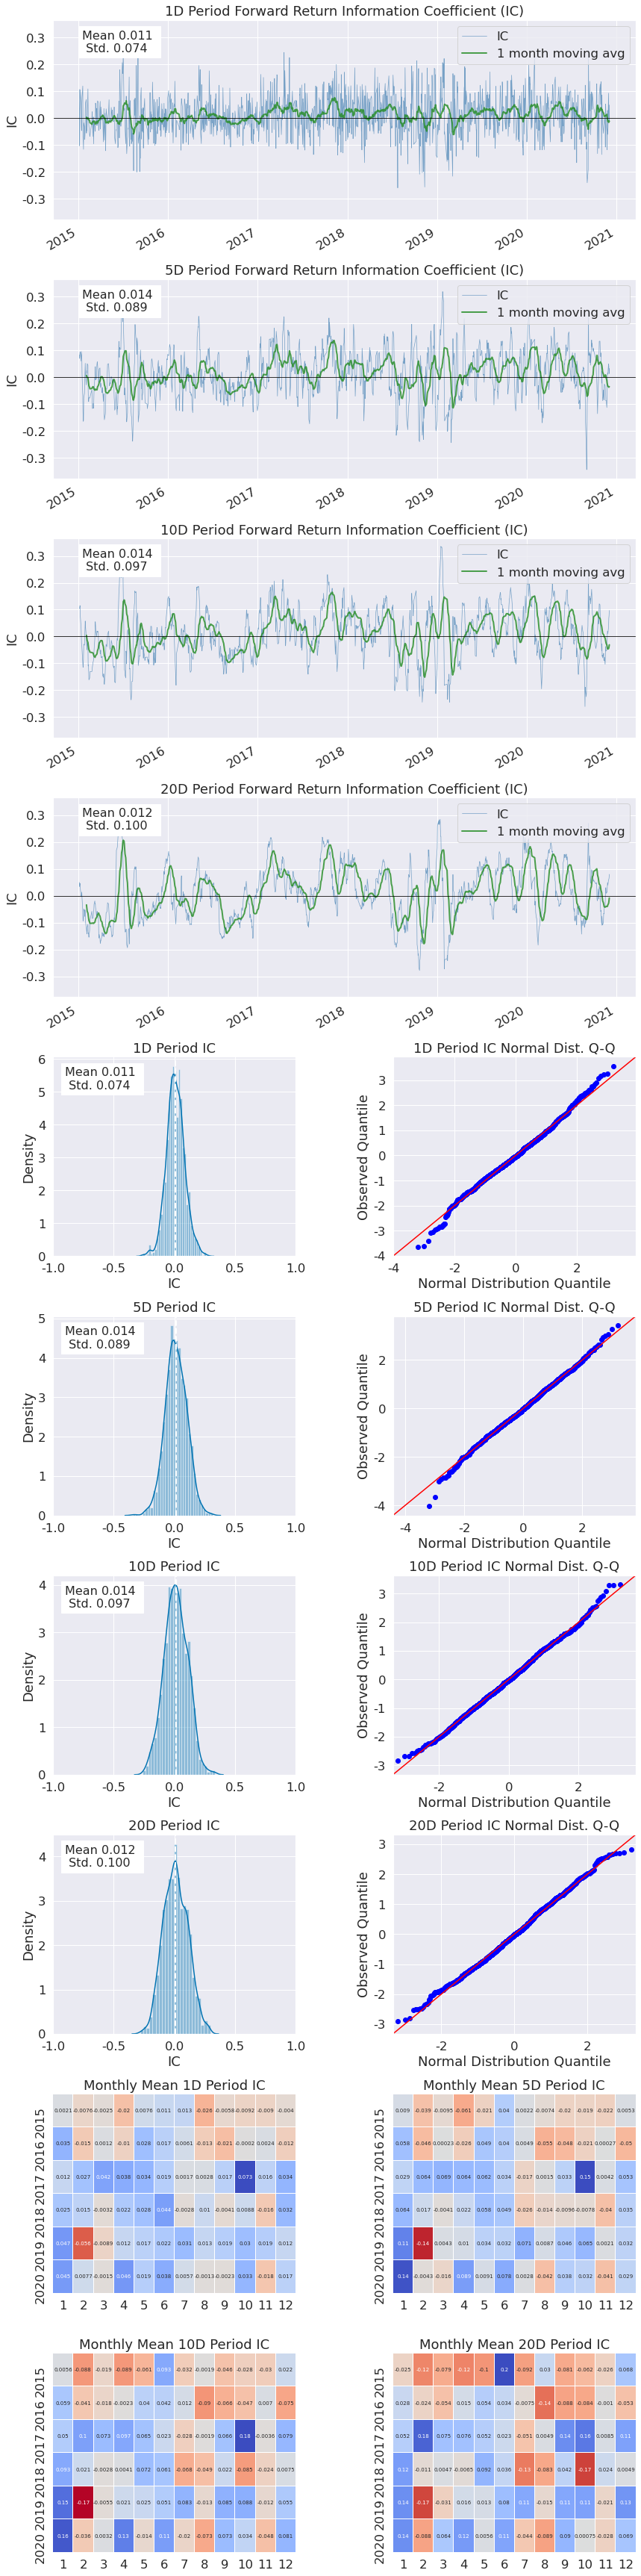

/usr/lib/miniconda3/lib/python3.8/site-packages/alphalens/utils.py:910: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


1D     5D    10D    20D
Quantile 1 Mean Turnover   0.020  0.066  0.107  0.174
Quantile 2 Mean Turnover   0.039  0.120  0.188  0.290
Quantile 3 Mean Turnover   0.044  0.144  0.224  0.339
Quantile 4 Mean Turnover   0.040  0.140  0.224  0.340
Quantile 5 Mean Turnover   0.024  0.089  0.146  0.230

1D     5D   10D    20D
Mean Factor Rank Autocorrelation  0.991  0.961  0.93  0.876

<Figure size 432x288 with 0 Axes>

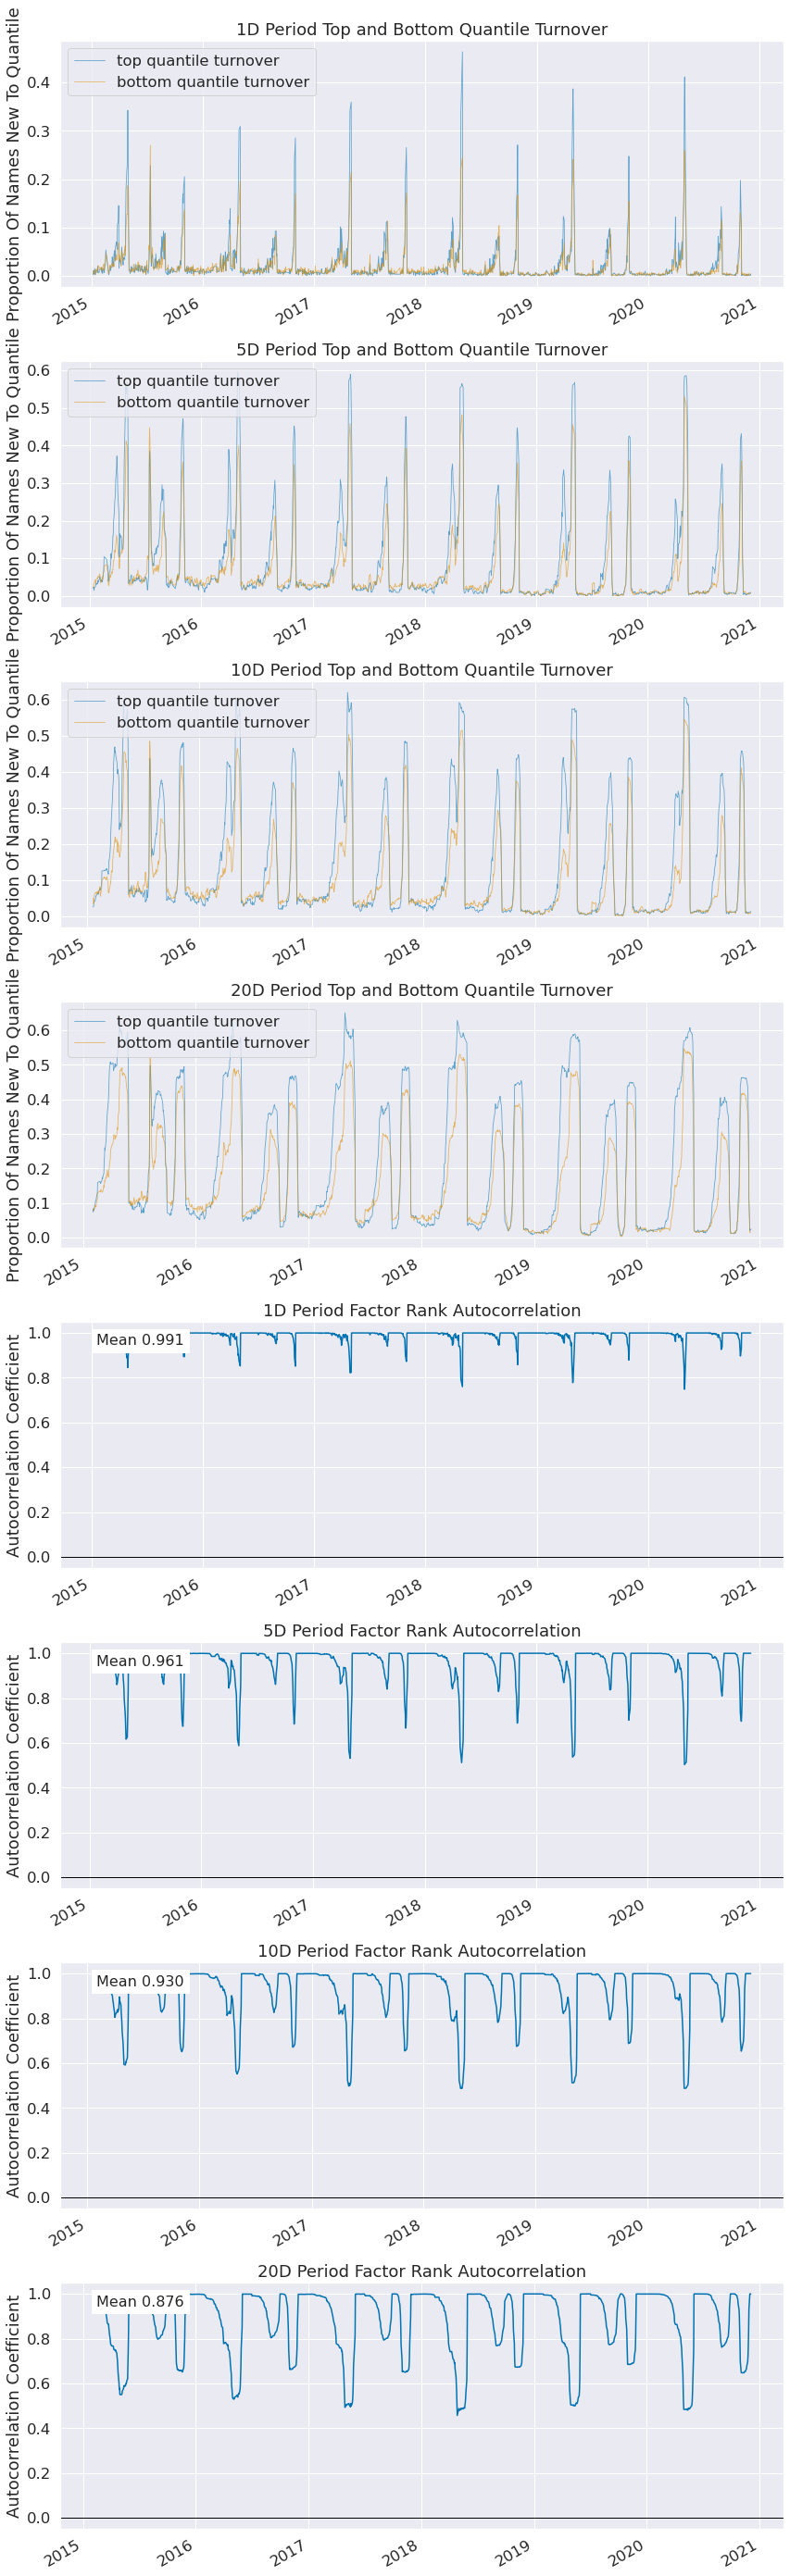

In [101]:
# Alphalens 回测结果

final=ret_5.set_index(["trade_date","ts_code"])
factor_init = final["std_neu_ROE"].copy()
price_df = final["close"].unstack().copy()
factor = al.utils.get_clean_factor_and_forward_returns(factor_init, price_df,quantiles=5, bins=None,periods=(1,5,10,20),max_loss=1)


factor = al.utils.get_clean_factor_and_forward_returns(factor_init, price_df,groupby=None,binning_by_group=False,quantiles=5,bins=None,periods=(1,5,10,20),filter_zscore=20,groupby_labels=None,max_loss=1,zero_aware=False,cumulative_returns=True)
al.tears.create_returns_tear_sheet(factor)
al.tears.create_information_tear_sheet(factor, group_neutral=False,by_group=False)
al.tears.create_turnover_tear_sheet(factor, turnover_periods=None)


In [110]:
balance_sheet_use

ticker         act_pubtime publish_date update_time  \
end_date   ts_code                                                          
2007-03-31 000001.SZ  000001 2007-04-25 18:00:00   2007-04-26  2019-07-25   
2007-06-30 000001.SZ  000001 2007-08-15 18:00:00   2007-08-16  2019-07-25   
2007-09-30 000001.SZ  000001 2007-10-22 18:00:00   2007-10-23  2019-07-25   
2007-12-31 000001.SZ  000001 2008-03-19 18:00:00   2008-03-20  2019-07-25   
2008-03-31 000001.SZ  000001 2008-04-23 18:00:00   2008-04-24  2019-07-25   
...                      ...                 ...          ...         ...   
2017-12-31 X16118.SZ  003033 2020-12-22 00:07:17   2020-12-22  2020-12-22   
2018-12-31 X16118.SZ  003033 2020-12-22 00:07:17   2020-12-22  2020-12-22   
2019-12-31 X16118.SZ  003033 2020-12-22 00:07:17   2020-12-22  2020-12-22   
2020-06-30 X16118.SZ  003033 2020-12-22 00:07:17   2020-12-22  2020-12-22   
2020-09-30 X16118.SZ  003033 2020-12-22 00:07:17   2020-12-22  2020-12-22   

                       t_sh_equity  preferred_stock_e   book_val_eq  
end_date   ts_code                                                   
2007-03-31 000001.SZ  7.106090e+09                0.0  7.106090e+09  
2007-06-30 000001.SZ  7.698480e+09                0.0  7.698480e+09  
2007-09-30 000001.SZ  8.363550e+09                0.0  8.363550e+09  
2007-12-31 000001.SZ  1.300610e+10                0.0  1.300610e+10  
2008-03-31 000001.SZ  1.404140e+10                0.0  1.404140e+10  
...                            ...                ...           ...  
2017-12-31 X16118.SZ  2.602650e+08                0.0  2.602650e+08  
2018-12-31 X16118.SZ  3.084120e+08                0.0  3.084120e+08  
2019-12-31 X16118.SZ  3.803960e+08                0.0  3.803960e+08  
2020-06-30 X16118.SZ  4.356040e+08                0.0  4.356040e+08  
2020-09-30 X16118.SZ  4.692020e+08                0.0  4.692020e+08  

[184623 rows x 7 columns]

In [112]:
conn=pymysql.connect(host='10.3.71.120',database='quant',user='root',password='stark12345+',port=3306)
sql='select ts_code,ticker,act_pubtime,publish_date,update_time,end_date,t_sh_equity,preferred_stock_e from stock_balance'
balance_sheet=pd.read_sql(sql,conn)


In [113]:
balance_sheet

ts_code  ticker         act_pubtime publish_date update_time  \
0       000001.SZ  000001 2007-04-25 18:00:00   2007-04-26  2019-07-25   
1       000001.SZ  000001 2007-08-15 18:00:00   2007-08-16  2019-07-25   
2       000001.SZ  000001 2007-10-22 18:00:00   2007-10-23  2019-07-25   
3       000001.SZ  000001 2008-03-19 18:00:00   2008-03-20  2019-07-25   
4       000001.SZ  000001 2008-04-23 18:00:00   2008-04-24  2019-07-25   
...           ...     ...                 ...          ...         ...   
724044  X16118.SZ  003033 2020-12-22 00:07:17   2020-12-22  2020-12-22   
724045  X16118.SZ  003033 2020-12-22 00:07:17   2020-12-22  2020-12-22   
724046  X16118.SZ  003033 2020-12-22 00:07:17   2020-12-22  2020-12-22   
724047  X16118.SZ  003033 2020-12-22 00:07:17   2020-12-22  2020-12-22   
724048  X16118.SZ  003033 2020-12-22 00:07:17   2020-12-22  2020-12-22   

          end_date   t_sh_equity  preferred_stock_e  
0       2007-03-31  7.106090e+09                NaN  
1       2007-06-30  7.698480e+09                NaN  
2       2007-09-30  8.363550e+09                NaN  
3       2007-12-31  1.300610e+10                NaN  
4       2007-12-31  1.300610e+10                NaN  
...            ...           ...                ...  
724044  2020-06-30  2.316900e+08                NaN  
724045  2019-12-31  3.803960e+08                NaN  
724046  2019-12-31  2.106980e+08                NaN  
724047  2020-09-30  4.692020e+08                NaN  
724048  2020-09-30  2.461040e+08                NaN  

[724049 rows x 8 columns]